In [1]:
import pandas as pd
import ewtpy
import pywt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import initializers

      name    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike   dew  humidity   precip  precipprob  precipcover preciptype  snow  snowdepth  windgust  windspeed  winddir  sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  uvindex  severerisk              sunrise               sunset  moonphase              conditions                                                                  description               icon                                                     stations
0    Hanoi  2010-05-19     36.5     26.0  30.8          48.1          26.0       38.4  26.3      78.1    0.000           0         0.00        NaN   NaN        NaN       NaN       20.5    102.6            1003.1        53.0        11.6           301.4         26.1       10         NaN  2010-05-19T05:17:34  2010-05-19T18:28:41       0.19        Partially cloudy                                            Partly cloudy throughout the day.  partly-cloudy-day                      

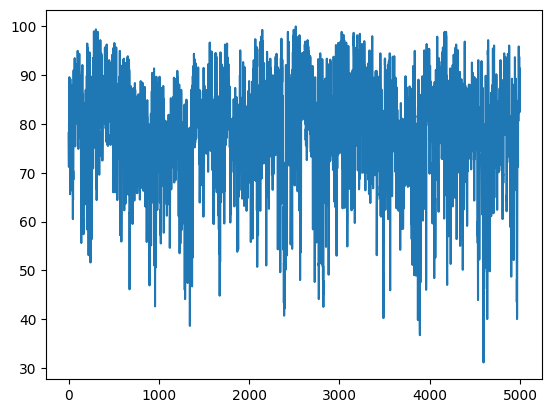

In [48]:
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
print(df.to_string())
data = df.to_numpy()
temp = df['temp'].to_numpy()
temp_max = df['tempmax'].to_numpy()
temp_min = df['tempmin'].to_numpy()

dew = df['dew'].to_numpy()
humidity = df['humidity'].to_numpy()


precipitation = df['precip'].to_numpy()
precipcover = df['precipcover'].to_numpy()
precipprob = df['precipprob'].to_numpy()

windspeed = df['windspeed'].to_numpy()
winddir = df['winddir'].to_numpy()

cloudcover = df['cloudcover'].to_numpy()
solar_radiation = df['solarradiation'].to_numpy()
solarenergy = df['solarenergy'].to_numpy()
uvindex = df['uvindex'].to_numpy()
moonphase = df['moonphase'].to_numpy()
date = df['datetime'].to_numpy()
training_set = np.array([humidity, temp, precipitation, precipprob, windspeed, solar_radiation])
plt.plot(humidity)

NUM = 0

In [49]:

training_set_tp = training_set.transpose()

In [50]:
def window_data(data, input_size, output_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(input_size + output_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(input_size + output_size))
    X = dataset.map(lambda window: (window[:-output_size]))
    y = dataset.map(lambda window: (window[-output_size:]))
    return X,y

In [106]:
input = 20
output = 10
X_tf,y_tf = window_data(training_set_tp, input, output)
X = np.array([x.numpy() for x in X_tf]).transpose(0,2,1)
y = np.array([y.numpy() for y in y_tf]).transpose(0,2,1)
print(X.shape)
print(y.shape)

(4967, 6, 20)
(4967, 6, 10)


In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True
)


In [108]:
model = Sequential(
    [
        tf.keras.Input(shape=(6,input,)),
        tf.keras.layers.Dense(units = 25, activation = "relu"),
        tf.keras.layers.Dense(units = 15, activation = "relu"),
        tf.keras.layers.Dense(units = 10, activation = "relu"),
        tf.keras.layers.Dense(units = 10, activation = "linear")
        ### END CODE HERE ### 
    ], name = "mlpnn_model" 
) 
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
)
print(X_train.shape)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist_mlpnn = model.fit(
    X_train,y_train,
    epochs=500,  
    # callbacks = [callback] 
) 

(3476, 6, 20)
Epoch 1/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8740.1602
Epoch 2/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1650.8524
Epoch 3/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1041.7302
Epoch 4/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1031.8538
Epoch 5/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1032.2439
Epoch 6/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1011.2151
Epoch 7/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1015.5767
Epoch 8/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 988.0256
Epoch 9/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 984.7829
Epoch 10/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1000.7957
Epoch 11/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 990.3760
Epoch 12/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 980.3005
Epoch 13/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1003.0546
Epoch 14/500
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9

In [ ]:
# model = Sequential(
#     [
#         tf.keras.Input(shape=(5,)),
#         tf.keras.layers.LSTM(units = 32),
#     ], name = "lstm_model" 
# ) 
# model.compile(
#     loss=tf.keras.losses.MeanSquaredError(),
#     optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
# )
# if (NUM != 0):
#     X_train = X_train[:-NUM]
# else:
#     X_train = X_train[:]
# print(X_train.shape)
# hist_mlpnn = model.fit(
#     X_train,y_train,
#     epochs=500,  
# ) 

In [ ]:
# model = Sequential(
#     [
#         tf.keras.Input(shape=(5,)),
#         tf.keras.layers.Dense(units = 2000, activation = "relu",kernel_initializer=initializers.RandomNormal(stddev=0.01),
#     bias_initializer=initializers.Zeros()),
#         tf.keras.layers.Dense(units = 1, activation = "linear")
#         ### END CODE HERE ### 
#     ], name = "elm_model" 
# ) 
# model.compile(
#     loss=tf.keras.losses.MeanSquaredError(),
#     optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
# )
# # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# if (NUM != 0):
#     X_train = X_train[:-NUM]
# else:
#     X_train = X_train[:]
# hist_elm = model.fit(
#     X_train,y_train,
#     epochs=1000,   
#     # callbacks = [callback]
# ) 


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(3476, 6, 10)
(3476, 6, 10)
TRAIN 1
R: [[1.         0.71707149]
 [0.71707149 1.        ]]
RMSE: 7.272590567883058
MAE: 5.546863838827925
TRAIN 2
R: [[1.         0.48972253]
 [0.48972253 1.        ]]
RMSE: 9.284015922688742
MAE: 7.223003392938366
TRAIN 3
R: [[1.         0.39471697]
 [0.39471697 1.        ]]
RMSE: 9.841905170548152
MAE: 7.629633760397399
TRAIN 4
R: [[1.         0.36226475]
 [0.36226475 1.        ]]
RMSE: 10.122896743851015
MAE: 7.9519290739702555
TRAIN 5
R: [[1.         0.33614462]
 [0.33614462 1.        ]]
RMSE: 10.276639159493307
MAE: 8.058197190050974
TRAIN 6
R: [[1.         0.31881248]
 [0.31881248 1.        ]]
RMSE: 10.275832796930134
MAE: 8.006055796791138
TRAIN 7
R: [[1.         0.28788272]
 [0.28788272 1.        ]]
RMSE: 10.42540883072139
MAE: 8.17867678147328
TRAIN 8
R: [[1.         0.27806034]
 [0.27806034 1.        ]]
RMSE: 10.500563703874002
MAE: 8.289071379157836
TRAIN 9
R: [[1. 

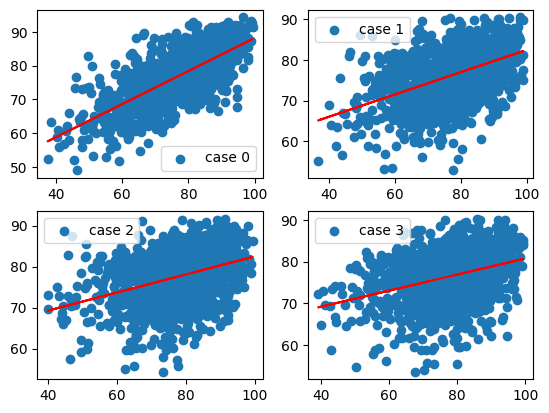

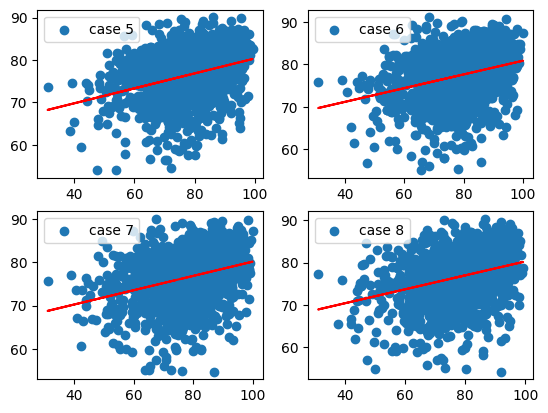

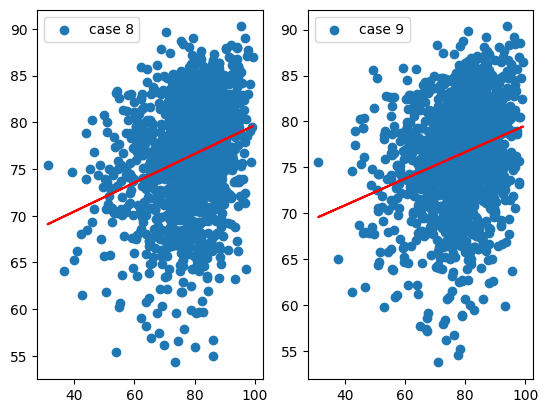

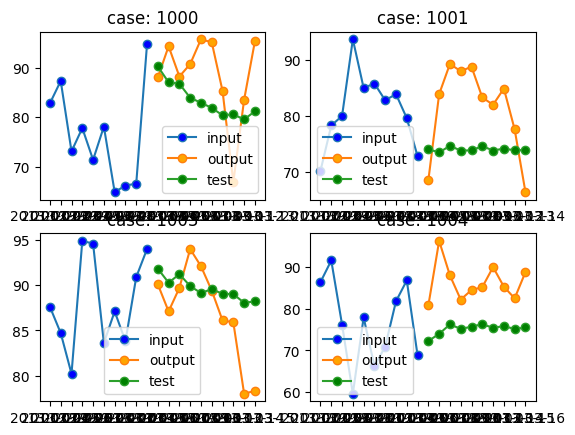

In [131]:
yt_predict = model.predict(X_train)
y_predict = model.predict(X_test)
print(yt_predict.shape)
print(y_train.shape)
feature = 0
for i in range(10):
    print(f"TRAIN {i+1}")
    print(f"R: {np.corrcoef(yt_predict[:,feature,i],y_train[:,feature,i])}")
    print(f"RMSE: {mean_squared_error(y_train[:,feature,i],yt_predict[:,feature,i])**(1/2)}")
    print(f"MAE: {mean_absolute_error(y_train[:,feature,i],yt_predict[:,feature,i])}")
for i in range(10):
    print(f"TRAIN {i+1}")
    print(f"R: {np.corrcoef(y_predict[:,feature,i],y_test[:,feature,i])}")
    print(f"RMSE: {mean_squared_error(y_test[:,feature,i],y_predict[:,feature,i])**(1/2)}")
    print(f"MAE: {mean_absolute_error(y_test[:,feature,i],y_predict[:,feature,i])}")


start_time = 1000
print(date.shape)
print(X_train.shape)
day = 0
figure, axis1 = plt.subplots(2,2)
figure, axis2 = plt.subplots(2,2)
figure, axis3 = plt.subplots(1,2)
for i in range(2):
    for j in range(2):
        axis1[i,j].scatter(y_test[:,feature,day],y_predict[:,feature,day], label = f"case {day}")
        axis1[i,j].legend()
        m, b = np.polyfit(y_test[:,feature,day],y_predict[:,feature,day], 1)
        axis1[i,j].plot(y_test[:,feature,day], m*y_test[:,feature,day]+b, color = "red")
        day+=1
for i in range(2):
    for j in range(2):
        axis2[i,j].scatter(y_test[:,feature,day],y_predict[:,feature,day], label = f"case {day + 1}")
        axis2[i,j].legend()
        m, b = np.polyfit(y_test[:,feature,day],y_predict[:,feature,day], 1)
        axis2[i,j].plot(y_test[:,feature,day], m*y_test[:,feature,day]+b, color = "red")
        day+=1
for i in range(2):
    axis3[i].scatter(y_test[:,feature,day],y_predict[:,feature,day], label = f"case {day}")
    axis3[i].legend()
    m, b = np.polyfit(y_test[:,feature,day],y_predict[:,feature,day], 1)
    axis3[i].plot(y_test[:,feature,day], m*y_test[:,feature,day]+b, color = "red")
    day+=1
# plt.plot(date[start_time+input-10:start_time+input],X_train[start_time,feature,input-10:input], label = "pre",marker = 'o', markerfacecolor = "blue")
# plt.plot(date[start_time+input:start_time+input+output],y_train[start_time,feature], label = "train",marker = 'o', markerfacecolor = "orange")
# plt.plot(date[start_time+input:start_time+input+output],yt_predict[start_time,feature], label = "test",marker = 'o', markerfacecolor = "green")
figure, axis = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        axis[i,j].set_title(f"case: {start_time + i}")
        axis[i,j].plot(date[start_time+input-10:start_time+input],X_test[start_time,feature,input-10:input], label = "input",marker = 'o', markerfacecolor = "blue")
        axis[i,j].plot(date[start_time+input:start_time+input+output],y_test[start_time,feature], label = "output",marker = 'o', markerfacecolor = "orange")
        axis[i,j].plot(date[start_time+input:start_time+input+output],y_predict[start_time,feature], label = "test",marker = 'o', markerfacecolor = "green")
        axis[i,j].legend()
        start_time += 1
# plt.plot(date[start_time+input-10:start_time+input],X_test[start_time,feature,input-10:input], label = "input",marker = 'o', markerfacecolor = "blue")
# plt.plot(date[start_time+input:start_time+input+output],y_test[start_time,feature], label = "output",marker = 'o', markerfacecolor = "orange")
# plt.plot(date[start_time+input:start_time+input+output],y_predict[start_time,feature], label = "test",marker = 'o', markerfacecolor = "green")
# plt.legend()
# for i in range(10):
#     print(f"train: {y_train[start_time,feature,i]}, test: {yt_predict[start_time,feature,i]}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
predict: [73.6504   72.5279   73.90934  72.5613   72.71546  73.838295 72.98825
 72.83925  72.900406 72.90728 ], test: [77.4 77.9 78.5 79.3 77.1 77.6 75.9 80.1 76.1 78.2]
predict: [70.71821  70.35431  72.03304  70.62116  71.065895 72.10303  71.079956
 71.091774 71.14266  71.33337 ], test: [71.4 72.2 69.4 81.9 76.  75.  86.4 77.2 61.1 68.7]
predict: [81.50149  79.822556 81.01768  79.95148  80.01434  81.17169  80.30088
 80.41183  80.50216  80.377594], test: [89.1 84.9 90.  84.9 87.7 96.7 85.2 82.5 88.7 91.2]
predict: [88.50649  84.156204 84.154274 82.62116  81.89423  82.79407  81.96857
 81.69026  81.87939  81.834755], test: [79.1 72.2 71.  66.5 71.5 79.7 77.9 86.5 89.7 82. ]
predict: [87.13742 85.22376 86.00749 84.69836 84.31968 84.81549 83.91397 84.15774
 83.71    83.98074], test: [83.3 81.7 79.9 74.5 83.  85.4 86.2 83.6 86.4 82.2]
predict: [80.26024 79.63535 81.13356 80.41427 80.50157 81.61599 80.93535 81.20

TypeError: expected 1D vector for x

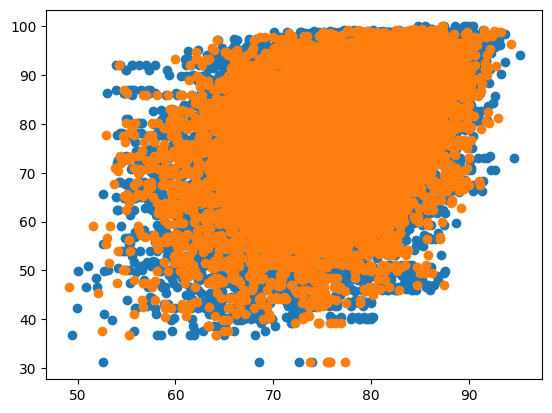

In [113]:
yt_predict = model.predict(X_train)
y_predict = model.predict(X_test)
plt.scatter(yt_predict[:,0],y_train[:,0])
plt.scatter(y_predict[:,0],y_test[:,0])
for i in range(len(y_predict) - NUM):
    print(f"predict: {y_predict[i,0]}, test: {y_test[i, 0]}")

print("TRAIN DETAIL")
print(f"R: {np.corrcoef(yt_predict[:,0],y_train[:,0])}")
print(f"RMSE: {mean_squared_error(y_train[:,0],yt_predict[:,0])**(1/2)}")
print(f"MAE: {mean_absolute_error(y_train[:,0],yt_predict[:,0])}")
# print(f"SCORE: {accuracy_score(y_train[:,0],yt_predict[:,0])}")
mt, bt = np.polyfit(yt_predict[:,0],y_train[:,0], 1)
plt.plot(yt_predict[:,0], mt*yt_predict[:,0]+bt, color = "yellow")
#add linear regression line to scatterplot 
print("TEST DETAIL")
print(f"R: {np.corrcoef(y_predict[:,0],y_test[:,0])}")
print(f"RMSE: {mean_squared_error(y_test[:,0],y_predict[:,0])**(1/2)}")
print(f"MAE: {mean_absolute_error(y_test[:,0],y_predict[:,0])}")
# print(f"SCORE: {accuracy_score(y_test[:,0],y_predict[:,0])}")
m, b = np.polyfit(y_predict[:,0],y_test[:,0], 1)
plt.plot(y_predict[:,0], m*y_predict[:,0]+b, color = "red")

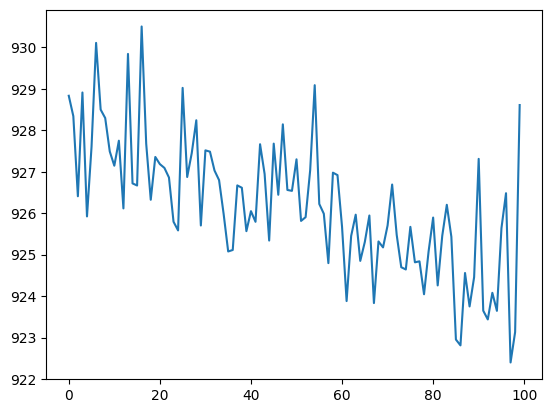

In [112]:
# plt.plot(history.history['loss'][200:500])
# print(history.history["loss"][400:500])
plt.plot(hist_mlpnn.history['loss'][400:500])

In [ ]:
plt.plot(y_predict, label = "predict")
plt.plot(y_test)
plt.plot(abs(y_predict - y_test))
plt.legend(['predict', 'test', 'loss'])